<a href="https://colab.research.google.com/github/NatashaKhotkina/Amino_acid_transfer_learning_for_antibody_binding_prediction/blob/main/Multi_task_for_AB_binding_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and settings

In [ ]:
!rm -rf data src

In [ ]:
!git clone https://github.com/NatashaKhotkina/Amino_acid_transfer_learning_for_antibody_binding_prediction.git
!mv Amino_acid_transfer_learning_for_antibody_binding_prediction/* .
!rm -rf Amino_acid_transfer_learning_for_antibody_binding_prediction
#!pip install -r requirements.txt

Cloning into 'Amino_acid_transfer_learning_for_antibody_binding_prediction'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 136 (delta 65), reused 93 (delta 29), pack-reused 0
Receiving objects: 100% (136/136), 9.01 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
import re

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import random
import seaborn as sns
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold

from src.dataset import make_dataloader
from src.models import LSTMModel, LSTMMultiModel
from src.train import train_model, train_multi_model
from src.validate import eval_model

In [ ]:
plt.rcParams["figure.figsize"] = 12, 9
plt.rcParams["font.size"] = 20
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))

Using device: cuda:0


# Training on different ly16 train size

In [ ]:
train_ly16 = pd.read_csv("data/LY16_train_data.csv")
test_ly16 = pd.read_csv("data/LY16_test_data.csv")

In [ ]:
batch_size = 256
check_sizes = [23000, 20000, 18000, 15000, 12000, 10000, 8000, 5000, 3000, 1000]
size_accuracy = defaultdict(list)
size_precision = defaultdict(list)
size_recall = defaultdict(list)
size_f1  = defaultdict(list)
size_roc_auc = defaultdict(list)

trainloader_ly16 = make_dataloader(train_ly16, batch_size=batch_size, shuffle=True)
testloader_ly16 = make_dataloader(test_ly16, batch_size=batch_size, shuffle=False)

lstm_ly16 =  LSTMModel(input_size = 20, hidden_size = 80, num_layers=3, dropout=0.2)
lstm_ly16 = lstm_ly16.to(device)
train_model(model=lstm_ly16, trainload=trainloader_ly16, num_epochs=20, 
            learning_rate=0.001, criterion=nn.BCEWithLogitsLoss, optim=torch.optim.Adam, 
            print_epoch=False, device=device)

mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc = eval_model(model=lstm_ly16, 
                                                                               testload=testloader_ly16, 
                                                                               device=device)
whole_dataset_len = len(train_ly16)
size_accuracy[whole_dataset_len].append(mean_accuracy)
size_precision[whole_dataset_len].append(mean_precision)
size_recall[whole_dataset_len].append(mean_recall)
size_f1[whole_dataset_len].append(mean_f1)
size_roc_auc[whole_dataset_len].append(mean_roc_auc)

n_ranges = 20
for i in range(n_ranges):

    for check_size in check_sizes:
        train_small, _ = train_test_split(train_ly16, train_size=check_size / whole_dataset_len, 
                                          random_state=SEED, stratify=train_ly16['Label'])
        trainloader_ly16 = make_dataloader(train_small, batch_size=batch_size, shuffle=True)

        lstm_ly16 =  LSTMModel(input_size = 20, hidden_size = 80, num_layers=3, dropout=0.2)
        lstm_ly16 = lstm_ly16.to(device)
        train_model(model=lstm_ly16, trainload=trainloader_ly16, num_epochs=int(20 * whole_dataset_len / check_size), 
            learning_rate=0.001, criterion=nn.BCEWithLogitsLoss, optim=torch.optim.Adam, 
            print_epoch=False, device=device)
        
        mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc = eval_model(model=lstm_ly16, 
                                                                               testload=testloader_ly16, 
                                                                               device=device)
        size_accuracy[check_size].append(mean_accuracy)
        size_precision[check_size].append(mean_precision)
        size_recall[check_size].append(mean_recall)
        size_f1[check_size].append(mean_f1)
        size_roc_auc[check_size].append(mean_roc_auc)

In [ ]:
metrics = {'accuracy': size_accuracy,
'precision': size_precision,
'recall': size_recall,
'f1': size_f1,
'roc_auc': size_roc_auc}

In [ ]:
for dictionary in metrics.values():
    dictionary[whole_dataset_len] = dictionary[whole_dataset_len] * n_ranges

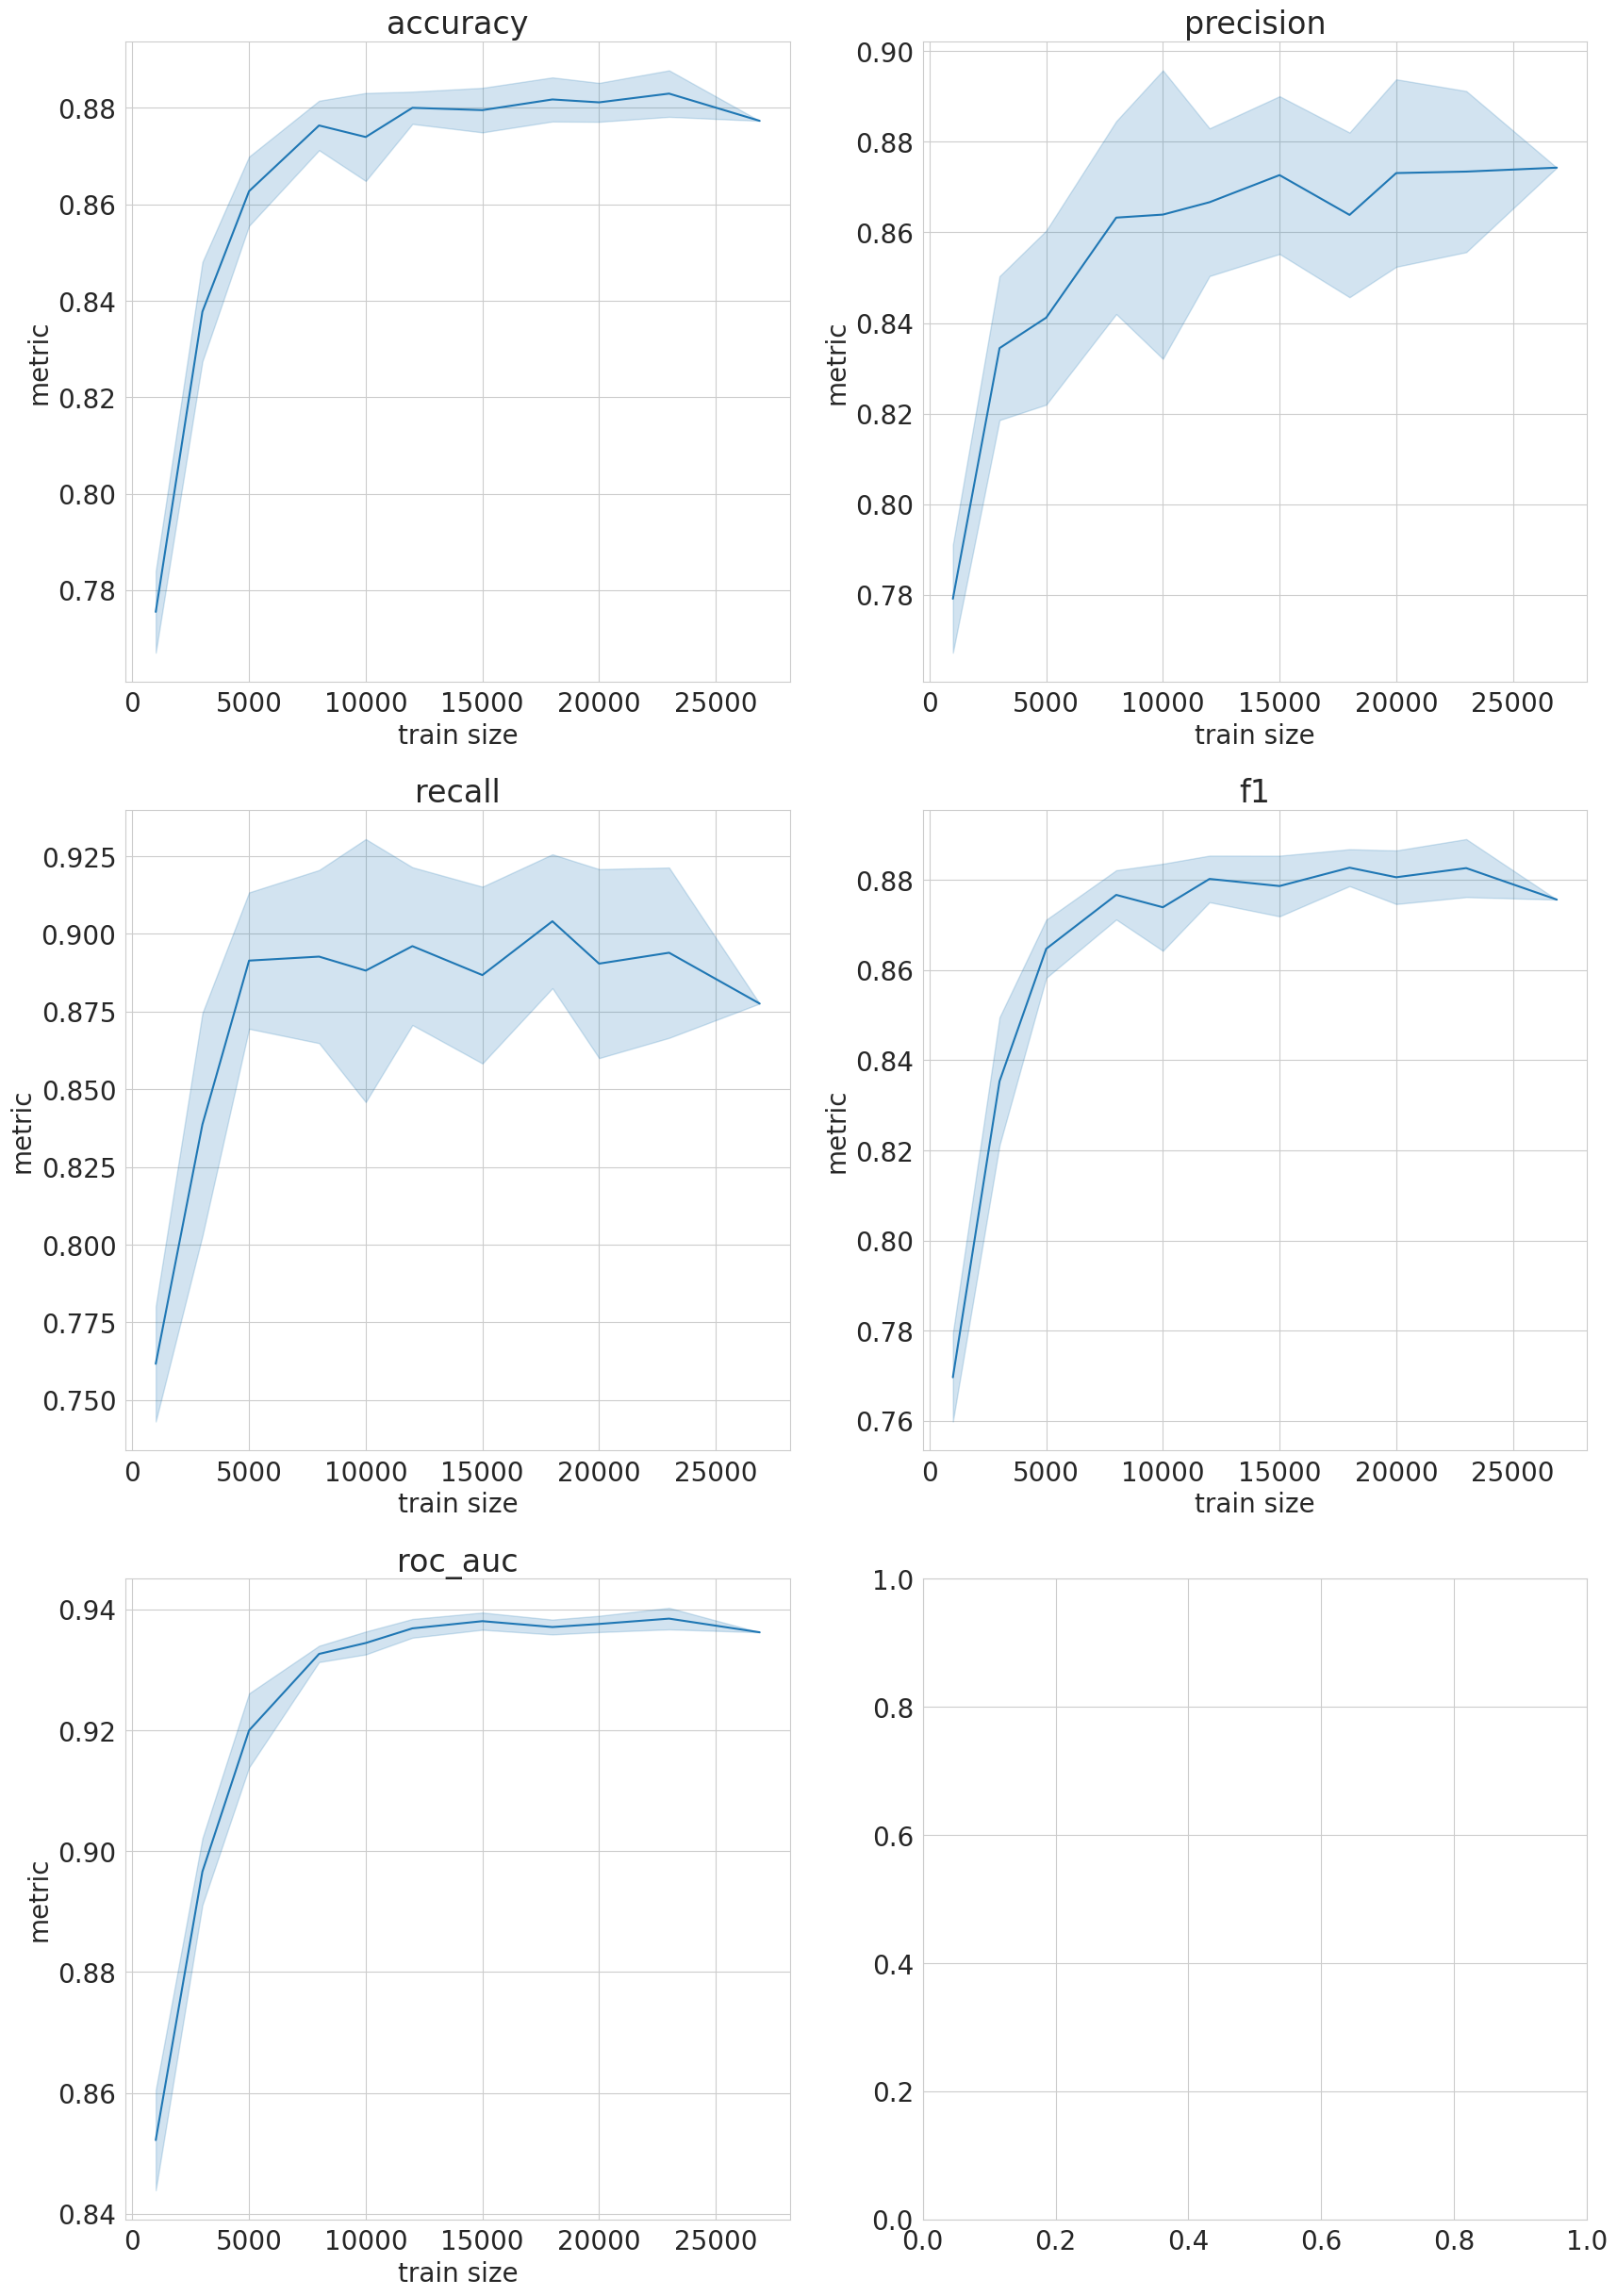

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(20, 30))
ax = ax.ravel()
for idx, (name, dictionary) in enumerate(metrics.items()):
    df = pd.DataFrame(dictionary).T.stack().reset_index().rename(columns={'level_0': 'train size', 0: 'metric'}).drop(columns=['level_1'])  
    sns.lineplot(x='train size', y='metric', data=df, errorbar='sd', ax=ax[idx]);
    ax[idx].set_title(name)

<ipython-input-49-78d449c9e079>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='train size', y='metric', data=df, errorbar='sd', palette="pastel");


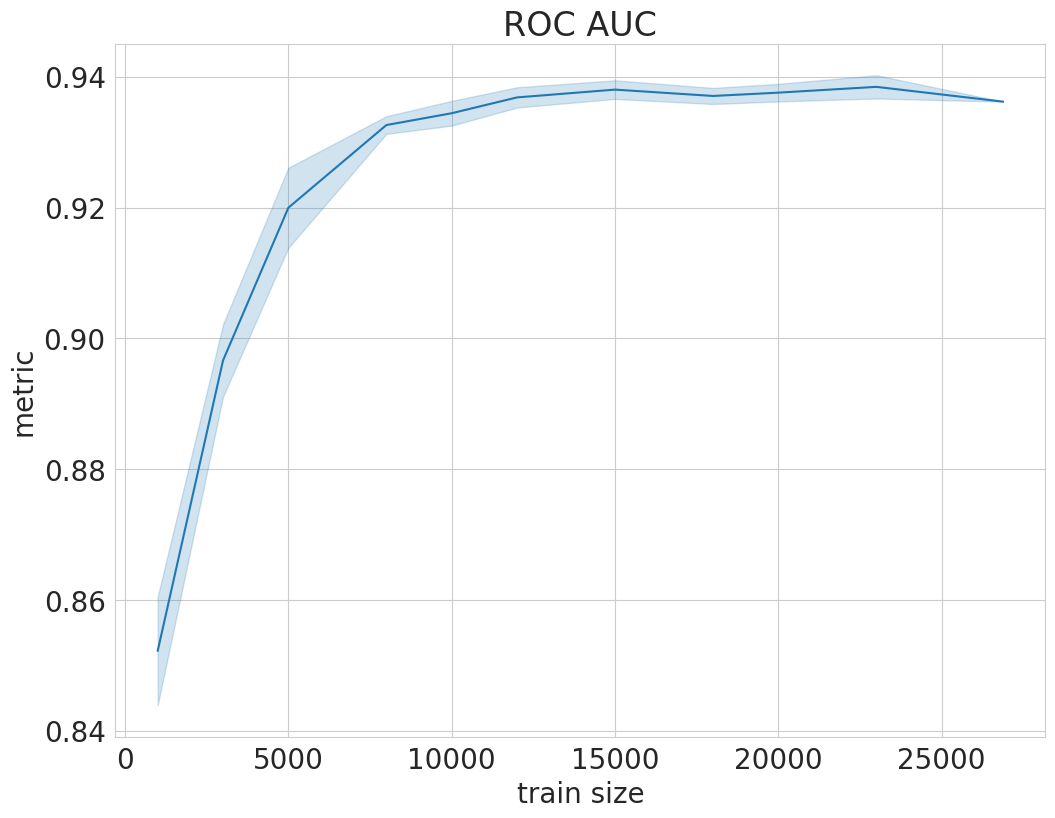

In [ ]:
df = pd.DataFrame(size_roc_auc).T.stack().reset_index().rename(columns={'level_0': 'train size', 0: 'metric'}).drop(columns=['level_1'])  
sns.lineplot(x='train size', y='metric', data=df, errorbar='sd', palette="pastel");
plt.title("ROC AUC")
plt.savefig("train_size.png")

In [ ]:
import json
  
with open('/content/gdrive/MyDrive/BI_project/metrics2.txt', 'w') as metric_file:
     metric_file.write(json.dumps(metrics))

# Multi-task

## Reading data

In [ ]:
train_ly16 = pd.read_csv("data/LY16_train_data.csv")
test_ly16 = pd.read_csv("data/LY16_test_data.csv")

train_ly16_small, _ = train_test_split(train_ly16, train_size=1000 / 26881, random_state=SEED, stratify=train_ly16['Label'])

In [ ]:
train_ly555 = pd.read_csv("data/LY555_train_data.csv")
test_ly555 = pd.read_csv("data/LY555_test_data.csv")

In [ ]:
train_REGN33 = pd.read_csv("data/REGN33_train_data.csv")
test_REGN33 = pd.read_csv("data/REGN33_test_data.csv")

In [ ]:
train_REGN87 = pd.read_csv("data/REGN87_train_data.csv")
test_REGN87 = pd.read_csv("data/REGN87_test_data.csv")

In [ ]:
train_REGN33.shape

(120218, 9)

In [ ]:
train_REGN33, _ = train_test_split(train_REGN33, train_size=30000 / 120218, 
                                          random_state=SEED, stratify=train_REGN33['Label'])

In [ ]:
train_ly555.shape

(15087, 9)

## Optuna

Here we search for best training hyperparametrs - learning rate and number of epochs.

### basic

In [ ]:
batch_size = 256
def objective(trial, train_loader, valid_loader):
    param = {
        "num_epochs": trial.suggest_int("num_epochs", 20, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.0005, 0.01),
    }
    lstm =  LSTMModel(input_size = 20, hidden_size = 80, num_layers=3, dropout=0.2)
    lstm = lstm.to(device)

    train_model(model=lstm, trainload=train_loader, num_epochs=param["num_epochs"], 
                learning_rate=param["learning_rate"], criterion=nn.BCEWithLogitsLoss, 
                optim=torch.optim.Adam, print_epoch=False, device=device)
    
    *_, mean_roc_auc = eval_model(model=lstm, testload=valid_loader, device=device)

    return mean_roc_auc


def objective_cv(trial):

    fold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []
    for cv_number, (train_idx, valid_idx) in enumerate(fold.split(range(len(train_ly16_small)))):
        train_data = train_ly16_small.iloc[train_idx, :]
        valid_data = train_ly16_small.iloc[valid_idx, :]

        train_loader = make_dataloader(train_data, batch_size=batch_size, shuffle=True)

        valid_loader = make_dataloader(valid_data, batch_size=batch_size, shuffle=True)

        roc_auc = objective(trial, train_loader, valid_loader)
        scores.append(roc_auc)

        trial.report(roc_auc, cv_number)

        if trial.should_prune():  # Stop trial if the metric for this epoch is bad.
            raise optuna.TrialPruned()

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective_cv, n_trials=100)

#clear_output()

In [ ]:
study.best_params, study.best_value

({'num_epochs': 568, 'learning_rate': 0.004568420560776651},
 0.8402508424266755)

### multi-task

In [ ]:
def custom_kfold(dataset, k):
    list_of_new_datasets = []
    rest = dataset
    for i in range(k - 1):
        new_dataset, rest = train_test_split(rest, train_size=1 / (k - i), 
                                          random_state=SEED, stratify=rest['Label'])
        list_of_new_datasets.append(new_dataset)
    list_of_new_datasets.append(rest)
    return list_of_new_datasets

In [ ]:
batch_size = 256
def multi_dataloaders(splitted_train, k, n_test):
    trainloaders = {}
    testloaders = {}
    train_indices = list(range(k))
    train_indices.remove(n_test)
    for ab_name, splitted_list in splitted_train.items():
        trainset = [splitted_list[i] for i in train_indices]
        trainset = pd.concat(trainset, ignore_index=True)
        testset = splitted_list[n_test]
        trainloaders[ab_name] = make_dataloader(trainset, batch_size=batch_size, shuffle=True)
        testloaders[ab_name] = make_dataloader(testset, batch_size=batch_size, shuffle=False)
    return trainloaders, testloaders

In [ ]:
def objective_multi(trial, train_loader, valid_loader):
    param = {
        "hidden_size": trial.suggest_int("hidden_size", 20, 120),
        "num_layers": trial.suggest_int("num_layers", 2, 3),
        "dropout": trial.suggest_float("dropout", 0.1, 0.9, step=0.1),
        "num_epochs": trial.suggest_int("num_epochs", 20, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.005),
        "target_num_epochs": trial.suggest_int("target_num_epochs", 100, 600),
    }
    lstm_multi =  LSTMMultiModel(input_size=20, hidden_size=param["hidden_size"], num_layers=param["num_layers"], 
                                 dropout=param["dropout"], device=device)
    lstm_multi = lstm_multi.to(device)

    train_multi_model(model=lstm_multi, trainload=train_loader, num_epochs=param["num_epochs"], 
                          learning_rate=param["learning_rate"], criterion=nn.BCEWithLogitsLoss, 
                          optim=torch.optim.Adam, print_epoch=False, device=device,
                          targeted_AB='ly16', target_num_epochs=param["target_num_epochs"])
        
    *_, mean_roc_auc = eval_model(model=lstm_multi, testload=valid_loader['ly16'], multi_task_targeted_AB='ly16', device=device)

    return mean_roc_auc


def objective_cv_multi(trial):
    
    k = 5
    splitted_train = {}
    splitted_train['ly16'] = custom_kfold(train_ly16_small, k)
    splitted_train['ly555'] = custom_kfold(train_ly555, k)
    splitted_train['REGN33'] = custom_kfold(train_REGN33, k)
    splitted_train['REGN87'] = custom_kfold(train_REGN87, k)
    scores = []

    for i in range(k):
        trainloaders, testloaders = multi_dataloaders(splitted_train, k, i)
        roc_auc = objective_multi(trial, trainloaders, testloaders)
        scores.append(roc_auc)

        trial.report(roc_auc, i)
        #print(f"Reported roc-auc {roc_auc} and split {k}")

        if trial.should_prune():  # Stop trial if the metric for this fold is bad.
            raise optuna.TrialPruned()

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective_cv_multi, n_trials=50)

#clear_output()

In [ ]:
study.best_params, study.best_value

({'hidden_size': 35,
  'num_layers': 3,
  'dropout': 0.5,
  'num_epochs': 77,
  'learning_rate': 0.004998943765660955,
  'target_num_epochs': 392},
 0.8646614141414142)

## Comparing basic model and multi-task in several runs with new **lr** and **num_epochs**

In [ ]:
batch_size = 256
trainloaders = {}
#testloaders = {}
trainloaders['ly555'] = make_dataloader(train_ly555, batch_size=batch_size, shuffle=True)
#testloaders['ly555'] = make_dataloader(test_ly555, batch_size=batch_size, shuffle=False)

trainloaders['REGN33'] = make_dataloader(train_REGN33, batch_size=batch_size, shuffle=True)
#testloaders['REGN33'] = make_dataloader(test_REGN33, batch_size=batch_size, shuffle=False)

trainloaders['REGN87'] = make_dataloader(train_REGN87, batch_size=batch_size, shuffle=True)
#testloaders['REGN87'] = make_dataloader(test_REGN87, batch_size=batch_size, shuffle=False)


trainloaders['ly16'] = make_dataloader(train_ly16, batch_size=batch_size, shuffle=True)
#testloaders['ly16'] = make_dataloader(test_ly16, batch_size=batch_size, shuffle=False)

Ly16 train size = 1000

In [ ]:
dict_accuracy = defaultdict(list)
dict_precision = defaultdict(list)
dict_recall = defaultdict(list)
dict_f1  = defaultdict(list)
dict_roc_auc = defaultdict(list)

model_types = ['basic', 'multi-task']

testloader_REGN87 = make_dataloader(test_REGN87, batch_size=batch_size, shuffle=False)
#testloader_ly16 = make_dataloader(test_ly16, batch_size=batch_size, shuffle=False)
#testloaders['ly16'] = testloader_ly16
whole_dataset_len = len(train_REGN87)

for _ in range(40):
    print(_)
    train_small, _ = train_test_split(train_REGN87, train_size=1000 / whole_dataset_len, 
                                          random_state=SEED, stratify=train_REGN87['Label'])
    trainloader_REGN87 = make_dataloader(train_small, batch_size=batch_size, shuffle=True)
    trainloaders['REGN87'] = trainloader_REGN87

    for model_type in model_types:
        if model_type == 'basic':
            lstm_REGN87 =  LSTMModel(input_size=20, hidden_size=80, num_layers=3, dropout=0.2).to(device)
            train_model(num_epochs=568, learning_rate=0.004568420560776651,
                        model=lstm_REGN87, trainload=trainloader_REGN87,
                        criterion=nn.BCEWithLogitsLoss, optim=torch.optim.Adam, print_epoch=False, device=device)
            
            mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc = eval_model(model=lstm_REGN87, testload=testloader_REGN87, 
                                                                                           device=device)
            
        elif model_type == 'multi-task':
            lstm_REGN87 =  LSTMMultiModel(input_size=20, hidden_size=114, num_layers=2, dropout=0.8, device=device).to(device)
            train_multi_model(num_epochs=36, learning_rate=0.0016846727912061695, target_num_epochs=115, 
                              model=lstm_REGN87, trainload=trainloaders, criterion=nn.BCEWithLogitsLoss,
                              optim=torch.optim.Adam, print_epoch=False, device=device, targeted_AB='REGN87')
            
            mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc = eval_model(model=lstm_REGN87, testload=testloader_REGN87, 
                                                                                           multi_task_targeted_AB='REGN87', device=device)

        dict_accuracy[model_type].append(mean_accuracy)
        dict_precision[model_type].append(mean_precision)
        dict_recall[model_type].append(mean_recall)
        dict_f1[model_type].append(mean_f1)
        dict_roc_auc[model_type].append(mean_roc_auc)

Save metrics.

In [ ]:
import json
from google.colab import files

In [ ]:
with open("accuracy_multi_and_basic_REGN33.json", "w") as write_file:
    json.dump(dict_accuracy, write_file)

with open("precision_multi_and_basic_REGN33.json", "w") as write_file:
    json.dump(dict_precision, write_file)

with open("recall_multi_and_basic_REGN33.json", "w") as write_file:
    json.dump(dict_recall, write_file)

with open("f1_multi_and_basic_REGN33.json", "w") as write_file:
    json.dump(dict_f1, write_file)

with open("roc_auc_multi_and_basic_REGN33.json", "w") as write_file:
    json.dump(dict_roc_auc, write_file)

In [ ]:
files.download("accuracy_multi_and_basic_REGN33.json")
files.download("precision_multi_and_basic_REGN33.json")
files.download("recall_multi_and_basic_REGN33.json")
files.download("f1_multi_and_basic_REGN33.json")
files.download("roc_auc_multi_and_basic_REGN33.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Upload metrics.

In [ ]:
with open("accuracy_multi_and_basic_attempt2.json", "r") as write_file:
    dict_accuracy = json.load(write_file)

with open("precision_multi_and_basic_attempt2.json", "r") as write_file:
    dict_precision = json.load(write_file)

with open("recall_multi_and_basic_attempt2.json", "r") as write_file:
    dict_recall = json.load(write_file)

with open("f1_multi_and_basic_attempt2.json", "r") as write_file:
    dict_f1 = json.load(write_file)

with open("roc_auc_multi_and_basic_attempt2.json", "r") as write_file:
    dict_roc_auc = json.load(write_file)

In [ ]:
metric_dicts = [dict_accuracy, dict_precision, dict_recall, dict_f1, dict_roc_auc]

In [ ]:
for metric_dict in metric_dicts:
    for name, values in metric_dict.items():
        print(name, np.mean(values))

basic 0.91240234375
multi-task 0.9413434709821427
basic 0.9116113059771858
multi-task 0.9395652706609156
basic 0.9208083574070063
multi-task 0.9483494227369755
basic 0.9153439064448794
multi-task 0.9433278003188985
basic 0.9570207263484928
multi-task 0.9755160781966155


In [ ]:
from scipy.stats import ttest_rel

In [ ]:
pvalue = ttest_rel(dict_roc_auc['basic'], dict_roc_auc['multi-task']).pvalue

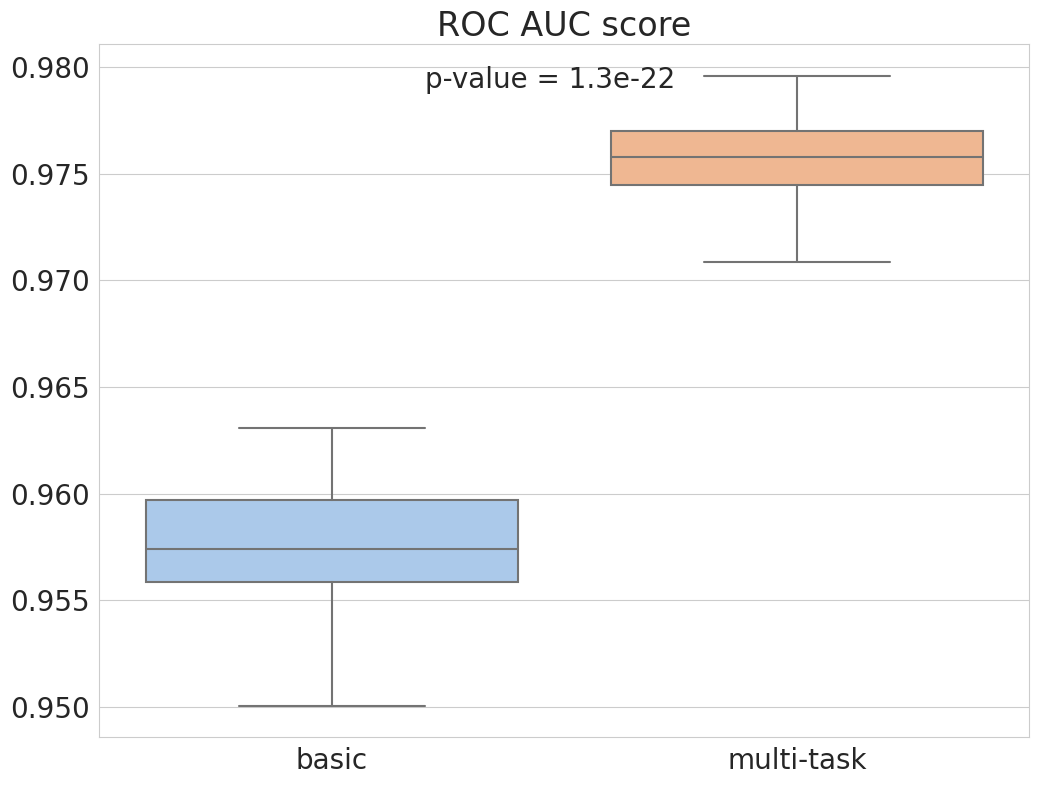

In [ ]:
sns.boxplot(pd.DataFrame(dict_roc_auc), palette="pastel", showfliers=False)
plt.title("ROC AUC score")
plt.text(0.2, 0.979, f"p-value = {pvalue:.1e}")
plt.savefig("roc_auc.png")